<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/B_MSDS458_Assignment_03_EDA_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## Experiments B: RNN

Try several experiments by tweaking 

(i) architecture 

(ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

## Functions and Packages

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import string
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import nltk
from nltk.corpus import stopwords

from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers.core import Dense
from keras.layers.core import Activation

### Verify TensorFlow version and Keras version

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


### Stopword Function

In [4]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

## Mount Google Drive to Colab Environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Load **Data**

In [6]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

2022-11-06 19:47:35.604896: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W1106 19:47:35.605276 140386896570240 download_and_prepare.py:43] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.text.ag_news_subset
2022-11-06 19:47:35.957485: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "NOT_FOUND: Error executing an HTTP request: HTTP response code 404".
INFO[dataset_info.py]: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
INFO[dataset_info.py]: Load dataset info from /tmp/tmpwy9l5n8ttfds
INFO[dataset_info.py]: Field info.spli

## Preparing Integer Sequence Datasets

In [8]:
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
max_length = 150
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Experiment B1: Bi-directional RNN One-Hot Encoded Vector Sequences

1 bio-directional layer (32)

Dropout 0.5

Output activation: softmax

In [10]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model1 = tf.keras.Model(inputs, outputs)
model1.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 1000)        0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               66112     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 66,372
Trainable params: 66,372
Non-trainable params: 0
_________________________________________________________

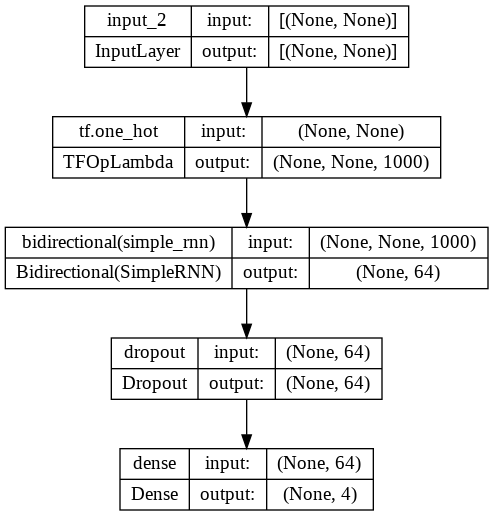

In [11]:
keras.utils.plot_model(model1, "BiDirectionalSimpleRNN.png", show_shapes=True)

In [12]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history1 = model1.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model1 = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model1.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 160s 44ms/step - loss: 0.6961 - accuracy: 0.7342 - val_loss: 0.4682 - val_accuracy: 0.8358
Epoch 2/200
3563/3563 [==============================] - 160s 45ms/step - loss: 0.4832 - accuracy: 0.8350 - val_loss: 0.4423 - val_accuracy: 0.8503
Epoch 3/200
3563/3563 [==============================] - 161s 45ms/step - loss: 0.4717 - accuracy: 0.8403 - val_loss: 0.4348 - val_accuracy: 0.8502
Epoch 4/200
3563/3563 [==============================] - 161s 45ms/step - loss: 0.4724 - accuracy: 0.8403 - val_loss: 0.4442 - val_accuracy: 0.8488
Epoch 5/200
238/238 [==============================] - 6s 24ms/step - loss: 0.4358 - accuracy: 0.8458
Test acc: 0.846


In [13]:
## Metrics
history_dict = history1.history
history_dict.keys()

losses = history1.history['loss']
accs = history1.history['accuracy']
val_losses = history1.history['val_loss']
val_accs = history1.history['val_accuracy']
epochs = len(losses)

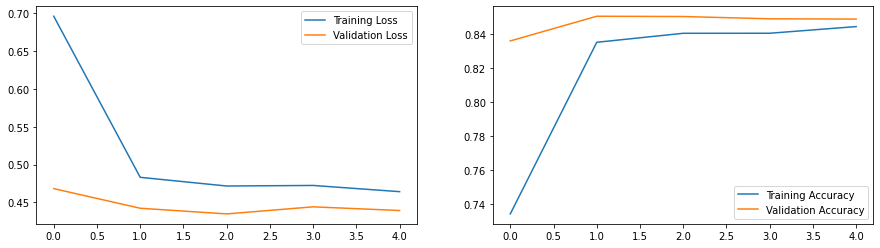

In [14]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Experiment B2: Bi-directional RNN One-Hot Encoded Vector Sequences

1 bio-directional layer (32)

Dropout 0.5

Output activation: Sigmoid

In [15]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="sigmoid")(x)
model2 = tf.keras.Model(inputs, outputs)
model2.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, None, 1000)        0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               66112     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 66,372
Trainable params: 66,372
Non-trainable params: 0
_______________________________________________________

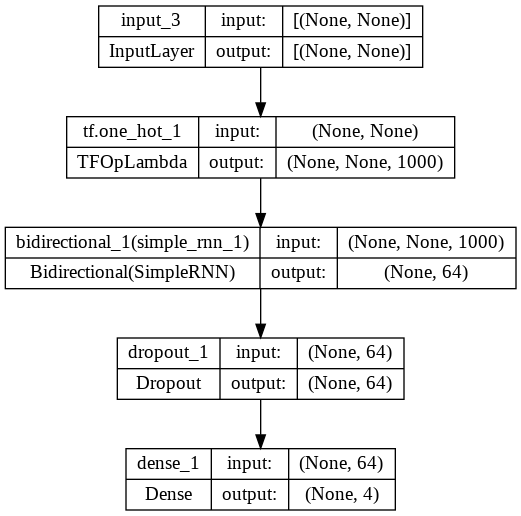

In [16]:
keras.utils.plot_model(model2, "BiDirectionalSimpleRNN2.png", show_shapes=True)

In [17]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history2 = model2.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model2 = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model2.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 165s 46ms/step - loss: 0.6194 - accuracy: 0.7709 - val_loss: 0.4579 - val_accuracy: 0.8437
Epoch 2/200
3563/3563 [==============================] - 163s 46ms/step - loss: 0.4710 - accuracy: 0.8397 - val_loss: 0.4261 - val_accuracy: 0.8550
Epoch 3/200
3563/3563 [==============================] - 163s 46ms/step - loss: 0.4567 - accuracy: 0.8471 - val_loss: 0.4279 - val_accuracy: 0.8555
Epoch 4/200
3563/3563 [==============================] - 162s 46ms/step - loss: 0.4515 - accuracy: 0.8492 - val_loss: 0.4358 - val_accuracy: 0.8543
Epoch 5/200
3563/3563 [==============================] - 162s 45ms/step - loss: 0.4459 - accuracy: 0.8507 - val_loss: 0.4342 - val_accuracy: 0.8552
Epoch 6/200
238/238 [==============================] - 6s 24ms/step - loss: 0.4283 - accuracy: 0.8529
Test acc: 0.853


In [18]:
## Metrics
history_dict = history2.history
history_dict.keys()

losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

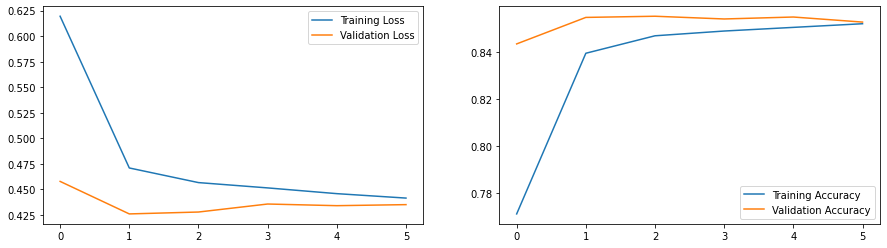

In [19]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Experiment B3: Unidirectional RNN One-Hot Encoded Vector Sequences

1 bio-directional layer (32)

Dropout 0.5

Output activation: Softmax

In [20]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.SimpleRNN(32)(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model3 = tf.keras.Model(inputs, outputs)
model3.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_2 (TFOpLambda)   (None, None, 1000)        0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                33056     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 33,188
Trainable params: 33,188
Non-trainable params: 0
_________________________________________________________________


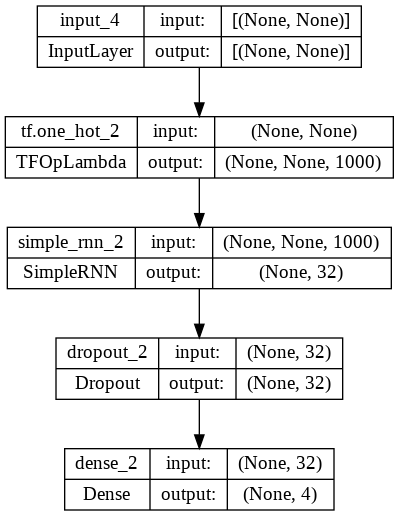

In [21]:
keras.utils.plot_model(model3, "UnidirectionalSimpleRNN3.png", show_shapes=True)

In [22]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history3 = model3.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model3 = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model3.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 126s 35ms/step - loss: 1.3887 - accuracy: 0.2525 - val_loss: 1.3866 - val_accuracy: 0.2515
Epoch 2/200
3563/3563 [==============================] - 125s 35ms/step - loss: 1.3875 - accuracy: 0.2512 - val_loss: 1.3866 - val_accuracy: 0.2515
Epoch 3/200
3563/3563 [==============================] - 126s 35ms/step - loss: 1.3876 - accuracy: 0.2497 - val_loss: 1.3865 - val_accuracy: 0.2515
Epoch 4/200
238/238 [==============================] - 4s 18ms/step - loss: 1.3865 - accuracy: 0.2500
Test acc: 0.250


In [23]:
## Metrics
history_dict = history3.history
history_dict.keys()

losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

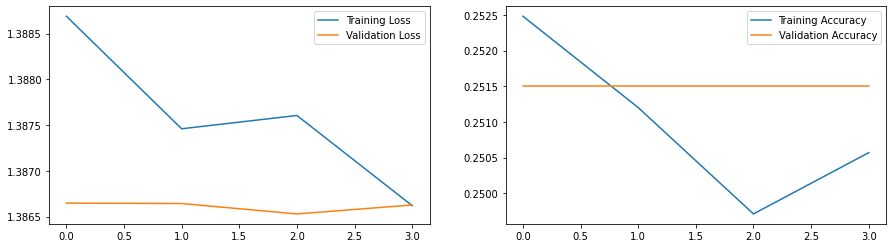

In [24]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Experiment B4: Bi-directional RNN One-Hot Encoded Vector Sequences

1 bio-directional layers (64)

Dropout 0.5

Output activation: softmax

In [25]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.SimpleRNN(64))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model4 = tf.keras.Model(inputs, outputs)
model4.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_3 (TFOpLambda)   (None, None, 1000)        0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              136320    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 136,836
Trainable params: 136,836
Non-trainable params: 0
_____________________________________________________

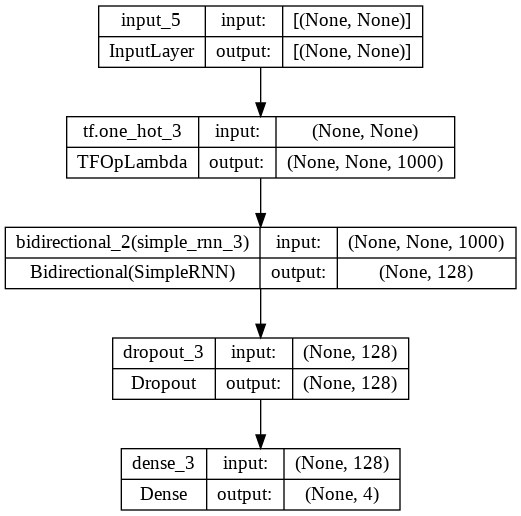

In [26]:
keras.utils.plot_model(model4, "BiDirectionalSimpleRNN2.png", show_shapes=True)

In [27]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history4 = model4.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model4 = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model4.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 255s 71ms/step - loss: 0.6518 - accuracy: 0.7544 - val_loss: 0.4592 - val_accuracy: 0.8385
Epoch 2/200
3563/3563 [==============================] - 254s 71ms/step - loss: 0.4802 - accuracy: 0.8330 - val_loss: 0.4349 - val_accuracy: 0.8515
Epoch 3/200
3563/3563 [==============================] - 253s 71ms/step - loss: 0.4629 - accuracy: 0.8402 - val_loss: 0.4553 - val_accuracy: 0.8422
Epoch 4/200
3563/3563 [==============================] - 252s 71ms/step - loss: 0.4446 - accuracy: 0.8471 - val_loss: 0.4366 - val_accuracy: 0.8477
Epoch 5/200
3563/3563 [==============================] - 252s 71ms/step - loss: 0.4302 - accuracy: 0.8531 - val_loss: 0.4337 - val_accuracy: 0.8523
Epoch 6/200
3563/3563 [==============================] - 254s 71ms/step - loss: 0.4236 - accuracy: 0.8554 - val_loss: 0.4325 - val_accuracy: 0.8502
Epoch 7/200
3563/3563 [==============================] - 254s 71ms/step - loss: 0.4164 - accuracy: 0.8592 - val_

In [28]:
## Metrics
history_dict = history2.history
history_dict.keys()

losses = history4.history['loss']
accs = history4.history['accuracy']
val_losses = history4.history['val_loss']
val_accs = history4.history['val_accuracy']
epochs = len(losses)

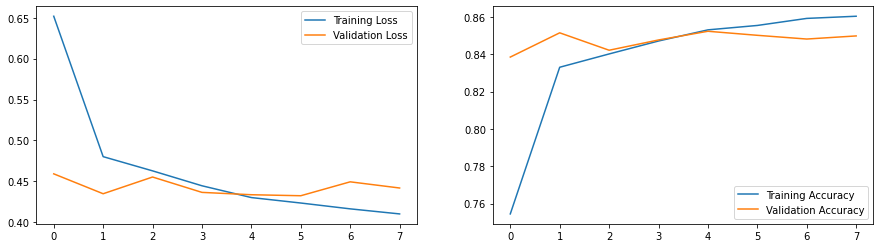

In [29]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Leveraging Trained Embedding Layer

In [30]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               18496     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 274,756
Trainable params: 274,756
Non-trainable params: 0
_____________________________________________________

In [31]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 160s 44ms/step - loss: 0.5845 - accuracy: 0.7957 - val_loss: 0.4590 - val_accuracy: 0.8452
Epoch 2/200
3563/3563 [==============================] - 158s 44ms/step - loss: 0.4931 - accuracy: 0.8342 - val_loss: 0.4469 - val_accuracy: 0.8500
Epoch 3/200
3563/3563 [==============================] - 157s 44ms/step - loss: 0.4669 - accuracy: 0.8438 - val_loss: 0.4346 - val_accuracy: 0.8522
Epoch 4/200
3563/3563 [==============================] - 158s 44ms/step - loss: 0.4550 - accuracy: 0.8484 - val_loss: 0.4333 - val_accuracy: 0.8510
Epoch 5/200
3563/3563 [==============================] - 158s 44ms/step - loss: 0.4487 - accuracy: 0.8512 - val_loss: 0.4275 - val_accuracy: 0.8562
Epoch 6/200
3563/3563 [==============================] - 157s 44ms/step - loss: 0.4428 - accuracy: 0.8531 - val_loss: 0.4323 - val_accuracy: 0.8532
Epoch 7/200
3563/3563 [==============================] - 156s 44ms/step - loss: 0.4350 - accuracy: 0.8555 - val_

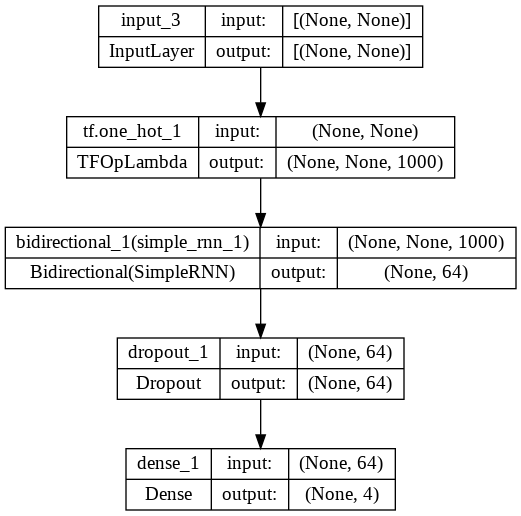

In [32]:
keras.utils.plot_model(model2, "BiDirectionalSimpleRNN2.png", show_shapes=True)

In [33]:
## Metrics
history_dict = history2.history
history_dict.keys()

losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

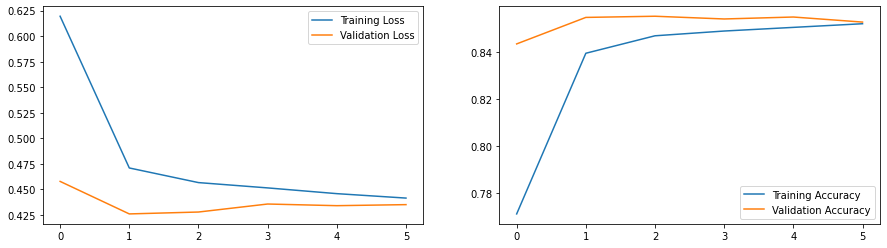

In [34]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()